In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB,ComplementNB

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

from myFunctions import plot_confusion_matrix, print_metrics,plot_feature_importances

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
%reload_ext autoreload

In [3]:
df = pd.read_csv('../Data/ModelData.csv',index_col=0)

In [4]:
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,10.0,3,2.70,1,0,75.56,10,717.2,0.105354,303
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,13.7,3,3.70,1,0,59.24,8,625.2,0.094754,332
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,12.2,5,3.29,0,0,62.29,11,539.4,0.115480,333
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,6.6,7,1.78,2,0,66.80,7,564.8,0.118272,255
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,10.1,3,2.73,3,0,52.09,6,512.0,0.101738,359


# Checking Correlation

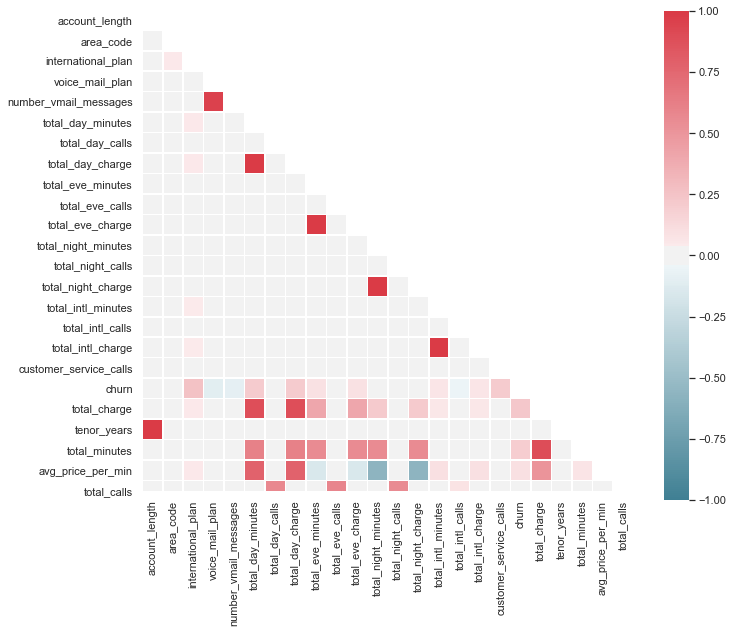

In [5]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap=cmap, vmax=1,vmin=-1, center=0,square=True,
            linewidths=.5)

In [388]:
dfchurn = df.loc[df['churn']==True]

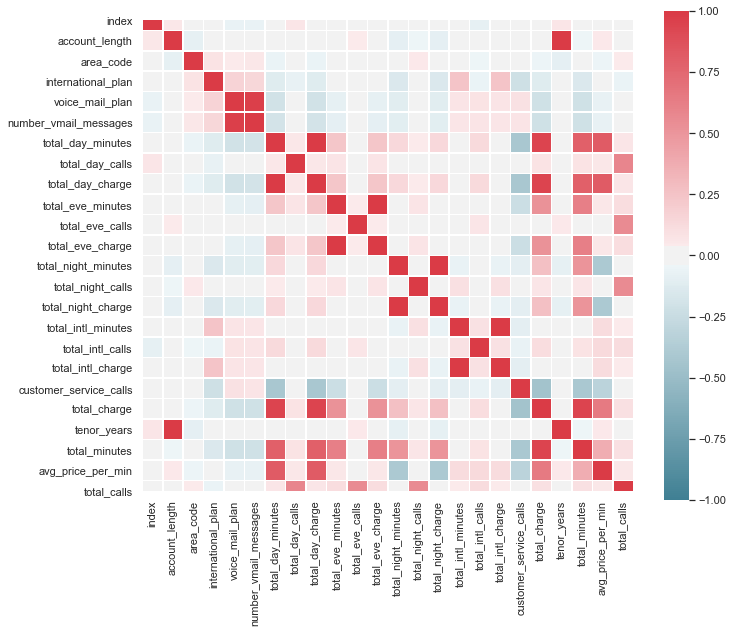

In [389]:
sns.set(style="white")

# Compute the correlation matrix
corr = dfchurn.drop('churn',axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, vmax=1,vmin=-1, center=0,square=True,
            linewidths=.5)

# Getting Data Ready for Modelling

In [5]:
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn', 'total_charge', 'tenor_years',
       'total_minutes', 'avg_price_per_min', 'total_calls'],
      dtype='object')

In [6]:
cols =['international_plan','voice_mail_plan','total_day_minutes','total_eve_minutes','total_night_minutes',
 'total_intl_minutes','total_intl_calls','customer_service_calls','total_charge','state']

In [7]:
dfnew = df[cols]
dfnew.head()

,international_plan,voice_mail_plan,total_day_minutes,total_eve_minutes,total_night_minutes,total_intl_minutes,total_intl_calls,customer_service_calls,total_charge,state
0,0,1,265.1,197.4,244.7,10.0,3,1,75.56,KS
1,0,1,161.6,195.5,254.4,13.7,3,1,59.24,OH
2,0,0,243.4,121.2,162.6,12.2,5,0,62.29,NJ
3,1,0,299.4,61.9,196.9,6.6,7,2,66.80,OH
4,1,0,166.7,148.3,186.9,10.1,3,3,52.09,OK


In [8]:
dfnew = pd.get_dummies(dfnew)

In [9]:
y = df['churn']
X = dfnew

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=df['churn'],random_state=100)

# Dealing with class imbalance

In [11]:
y.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [12]:
smote = SMOTE()

In [13]:
X_train_smote , y_train_smote = smote.fit_sample(X_train,y_train)

In [14]:
from collections import Counter

In [15]:
y_train_smote_counter = Counter(y_train_smote)

In [16]:
y_train.value_counts(), y_train_smote_counter

(0    2280
 1     386
 Name: churn, dtype: int64, Counter({0: 2280, 1: 2280}))

In [17]:

## KEEP IT FOR NOW
# Construct some pipelines
logreg_pipeline = Pipeline([('ss', StandardScaler()), 
                              ('logreg',LogisticRegression(solver='liblinear'))])
        
rf_pipeline = Pipeline([('ss', StandardScaler()),('RF',RandomForestClassifier())])

xgb_pipeline = Pipeline([('ss',StandardScaler()),('xgb',xgb.XGBClassifier(objective='binary:logistic'))])

# List of pipelines and pipeline names
pipelines = [logreg_pipeline,rf_pipeline,xgb_pipeline]
pipeline_names = ['Logistic Regresion','Random Forest','XGBoost']

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train_smote, y_train_smote)

# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('RF',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_f

In [21]:
# Your code here
# ⏰ This cell may take a long time to run!
xgb_pipeline = Pipeline([('ss',StandardScaler()),('xgb',xgb.XGBClassifier(objective='binary:logistic'))])

# Set grid search params
params = {
    "xgb__learning_rate": [0.001,0.05,0.01,0.1,0.5],
    'xgb__max_depth': [3,5,7],
    'xgb__subsample': [1],
    'xgb__n_estimators': [5, 50, 100, 250,500,750],
}

# Construct grid search
gs_rf = GridSearchCV(estimator=xgb_pipeline, 
                     param_grid=params, 
                     n_jobs=-1,
                            scoring=make_scorer(recall_score),cv=5)

# Fit using grid search
gs_rf.fit(X_train_smote, y_train_smote)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Best accuracy: 0.968

Best params:
 {'xgb__learning_rate': 0.05, 'xgb__max_depth': 7, 'xgb__n_estimators': 750, 'xgb__subsample': 1}


In [22]:
xgb_best_smote = gs_rf.best_estimator_

In [24]:
xgb_best_smote.score(X_train_smote,y_train_smote),xgb_best_smote.score(X_test,y_test),xgb_best_smote.score(X_train,y_train)

(1.0, 0.9835082458770614, 1.0)

In [25]:
xgb_preds_smote = xgb_best_smote.predict(X_test)

0.0 of False Negatives


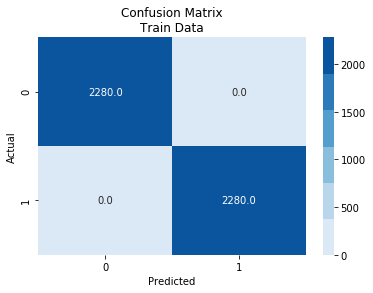

Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0


In [26]:
plot_confusion_matrix(y_train_smote,xgb_best_smote.predict(X_train_smote),data='Train')
print_metrics(y_train_smote,xgb_best_smote.predict(X_train_smote))

1.3493253373313343 of False Negatives


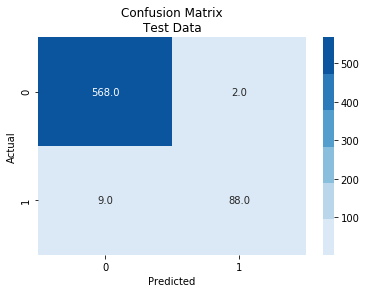

Precision Score: 0.9777777777777777
Recall Score: 0.9072164948453608
Accuracy Score: 0.9835082458770614
F1 Score: 0.9411764705882353


In [27]:
plot_confusion_matrix(y_test,xgb_preds_smote,data='Test')
print_metrics(y_test,xgb_preds_smote)

0.27002700270027 of False Negatives


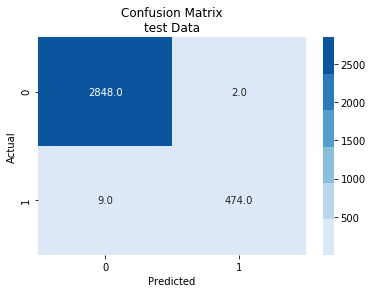

Precision Score: 0.9957983193277311
Recall Score: 0.9813664596273292
Accuracy Score: 0.9966996699669967
F1 Score: 0.9885297184567259


In [28]:
plot_confusion_matrix(y,xgb_best_smote.predict(X))
print_metrics(y,xgb_best_smote.predict(X))

0.0 of False Negatives


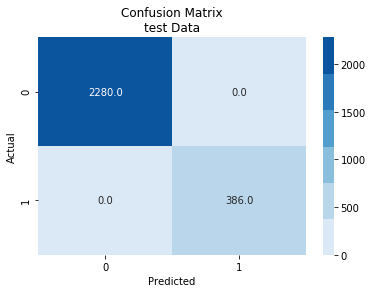

Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0


In [32]:
plot_confusion_matrix(y_train,xgb_best_smote.predict(X_train))
print_metrics(y_train,xgb_best_smote.predict(X_train))

In [40]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

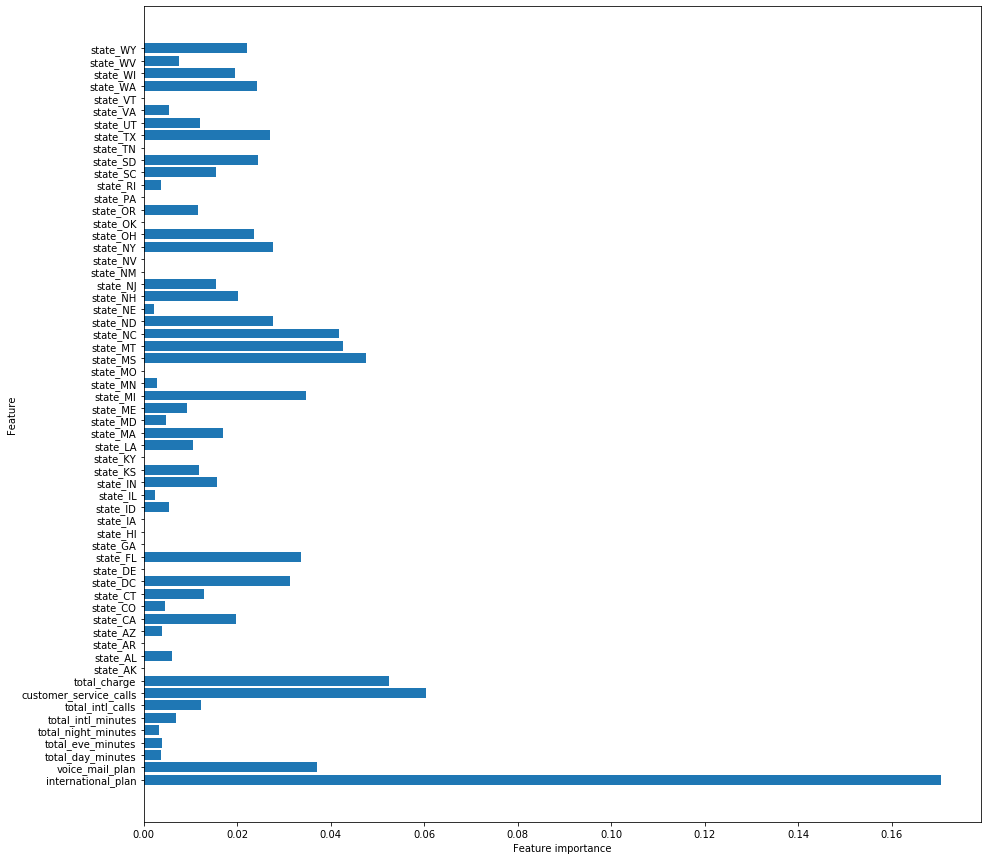

In [41]:
plot_feature_importances(xgb_best_smote[1])

# Is there a threshold to reduce False Negatives?

In [45]:
# let's try a 20% threshold to make our labels

def xgb_labels(X_test, thresh=0.2):
    """
    custom predict method
    """
    probs = xgb_best_smote.predict_proba(X_test)[:, 1]
    labels = []
    for prob in probs:
        if prob >= thresh:
            labels.append(1)
        else:
            labels.append(0)
    return labels

1.199400299850075 of False Negatives


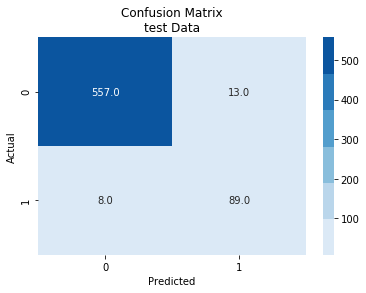

In [48]:
xgb_best_smote.predict_custom = xgb_labels
new_labels = xgb_best_smote.predict_custom(X_test,thresh=0.1)
plot_confusion_matrix(y_test, new_labels)

In [49]:
xgb_best_smote.predict_custom = xgb_labels

1.3493253373313343 of False Negatives


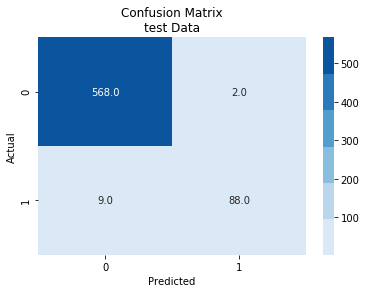

In [50]:
plot_confusion_matrix(y_test,xgb_preds_smote)

1.199400299850075 of False Negatives


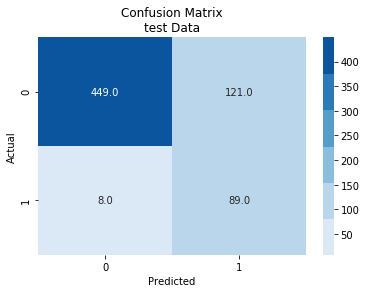

In [53]:
new_labels = xgb_best_smote.predict_custom(X_test,thresh=0.01)
plot_confusion_matrix(y_test, new_labels)

1.199400299850075 of False Negatives


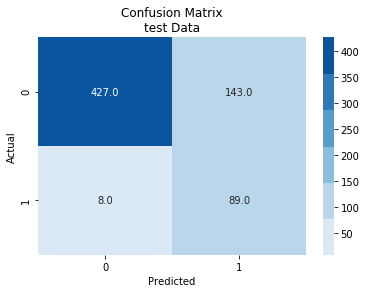

In [54]:
new_labels = xgb_best_smote.predict_custom(X_test,thresh=0.008)
plot_confusion_matrix(y_test, new_labels)

IT is clear that as FN go to 0 , FP get extremely large. This is because our model predicts nearly everything as 
a churn - to make sure that we dont accidentally say they wont churn if they will
This makes our model a bit redundant

# Exploring the False Negatives for Test Set

In [55]:
d = {'y_test':y_test,'y_pred':xgb_preds_smote}

In [56]:
dfpreds = pd.DataFrame(data=d)

In [57]:
dfpreds['correct'] = dfpreds['y_test']==dfpreds['y_pred']

In [58]:
dfpreds['correct'].value_counts()

True     656
False     11
Name: correct, dtype: int64

In [60]:
dfcorrect = dfpreds.loc[(dfpreds['correct']==False)&(dfpreds['y_pred']==0)]

In [61]:
indexlist = dfcorrect.index.values.tolist()  # an ndarray method, you probably shouldn't depend on this


In [62]:
FN = dfcorrect.loc[dfcorrect['y_pred']==0]

In [63]:
FN

,y_test,y_pred,correct
2575,1,0,False
1939,1,0,False
2357,1,0,False
3070,1,0,False
1551,1,0,False
2377,1,0,False
2535,1,0,False
198,1,0,False
1030,1,0,False


In [64]:
indexlist = FN.index.values.tolist()  # an ndarray method, you probably shouldn't depend on this
indexlist

[2575, 1939, 2357, 3070, 1551, 2377, 2535, 198, 1030]

In [65]:
dfFN = df.loc[indexlist]

In [66]:
dfFN

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
2575,MS,131,415,333-9002,0,0,0,131.6,95,22.37,...,15.5,3,4.19,1,1,53.10,10,577.6,0.091932,336
1939,AZ,113,510,403-9719,0,0,0,128.7,100,21.88,...,9.2,4,2.48,2,1,51.67,9,543.1,0.095139,306
2357,WI,153,510,349-3112,0,0,0,159.5,103,27.12,...,10.1,2,2.73,1,1,61.22,12,621.8,0.098456,321
3070,MD,154,510,411-2977,0,0,0,154.5,122,26.27,...,12.0,2,3.24,3,1,55.73,12,558.7,0.099749,300
1551,MI,225,415,371-2500,0,0,0,165.4,106,28.12,...,8.7,3,2.35,0,1,63.18,18,657.8,0.096047,311
2377,ND,101,415,364-5510,0,1,36,123.7,125,21.03,...,8.8,4,2.38,1,1,50.70,8,585.6,0.086578,362
2535,RI,125,408,410-3159,0,0,0,113.0,108,19.21,...,9.2,5,2.48,2,1,43.12,10,448.0,0.096250,281
198,ME,131,510,353-7292,1,1,26,292.9,101,49.79,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332
1030,VA,99,415,400-6257,0,1,42,216.0,125,36.72,...,9.3,4,2.51,2,1,68.68,8,673.1,0.102035,333


In [67]:
df.loc[df['churn']==0]['total_charge'].mean()

58.448807017543864

In [68]:
dfFN.loc[dfFN['total_charge']<60]

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
2575,MS,131,415,333-9002,0,0,0,131.6,95,22.37,...,15.5,3,4.19,1,1,53.10,10,577.6,0.091932,336
1939,AZ,113,510,403-9719,0,0,0,128.7,100,21.88,...,9.2,4,2.48,2,1,51.67,9,543.1,0.095139,306
3070,MD,154,510,411-2977,0,0,0,154.5,122,26.27,...,12.0,2,3.24,3,1,55.73,12,558.7,0.099749,300
2377,ND,101,415,364-5510,0,1,36,123.7,125,21.03,...,8.8,4,2.38,1,1,50.70,8,585.6,0.086578,362
2535,RI,125,408,410-3159,0,0,0,113.0,108,19.21,...,9.2,5,2.48,2,1,43.12,10,448.0,0.096250,281


5 out of 9 data points had a total charge less than 60. This is the most important feature in our model and assumes charges above average will be more liekly to churn

In [69]:
dfFN.loc[dfFN['customer_service_calls']>3]

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
198,ME,131,510,353-7292,1,1,26,292.9,101,49.79,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332


Only 1 out of the 9 False Negatives made more than 3 customer services calls
- This shows that our model struggles to classify points when customers dont make a lot of customer service calls

In [70]:
dfFN.loc[dfFN['international_plan']==1]

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
198,ME,131,510,353-7292,1,1,26,292.9,101,49.79,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332


Only 1 of the 9 values had an international plan.
Again our model puts a lot of bias on international plans churning so this is why it is classified incorrectly

## Conclusion:

Looking at the False Negatives from our test set - that is we predicted them to stay and they churned, I wanted to see what these data points had in common

8/9 of them had made less than 3 calls to customer service
only 1/9 of them had an international plan
5/9 paid less than the average charge for the whole dataset

This leads me to belive that these points lie within the unpredictable - there is no partiular reason from a business case why they left, and is proabbly down to customer descretion and personal circumstances

# Exploring False Negatives for Entire DataSet

0.27002700270027 of False Negatives


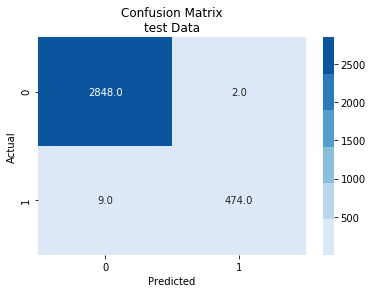

Precision Score: 0.9957983193277311
Recall Score: 0.9813664596273292
Accuracy Score: 0.9966996699669967
F1 Score: 0.9885297184567259


In [71]:
plot_confusion_matrix(y,xgb_best_smote.predict(X))
print_metrics(y,xgb_best_smote.predict(X))

In [72]:
d = {'y':y,'y_pred':xgb_best_smote.predict(X)}

In [73]:
dfpredswhole = pd.DataFrame(data=d)
dfpredswhole

,y,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3328,0,0
3329,0,0
3330,0,0
3331,0,0


In [74]:
dfpredswhole['correct'] = dfpredswhole['y']==dfpredswhole['y_pred']

In [75]:
FN_whole = dfpredswhole.loc[(dfpredswhole['correct']==False) & (dfpredswhole['y_pred']==0)]

In [76]:
FN_whole.shape

(9, 3)

In [77]:
indexlist = FN_whole.index.values.tolist() 

In [78]:
FN_whole_data = df.loc[indexlist]

In [79]:
df.loc[df['churn']==0]['total_charge'].mean()

58.448807017543864

In [80]:
FN_whole_data.loc[FN_whole_data['total_charge']<60].shape

(5, 26)

26 out of the 48 data points had a total charge less than 60. This is the most important feature in our model and assumes charges above average will be more liekly to churn

In [81]:
FN_whole_data.loc[FN_whole_data['customer_service_calls']>3]

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
198,ME,131,510,353-7292,1,1,26,292.9,101,49.79,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332


Only 1 out of the 48 False Negatives made more than 3 customer services calls
- This shows that our model struggles to classify points when customers dont make a lot of customer service calls

In [262]:
FN_whole_data.loc[FN_whole_data['international_plan']==1]

,index,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
198,198,ME,131,510,353-7292,1,1,26,292.9,101,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332


Only 1 of the 48 values had an international plan.
Again our model puts a lot of bias on international plans churning so this is why it is classified incorrectly

In [264]:
FN_whole_data.loc[FN_whole_data['voice_mail_plan']==1]

,index,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
57,57,CO,121,408,370-7574,0,1,30,198.4,129,...,5.8,3,1.57,3,1,49.85,10,460.7,0.108205,286
198,198,ME,131,510,353-7292,1,1,26,292.9,101,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332
277,277,SD,144,408,339-3049,0,1,48,189.8,96,...,6.5,2,1.76,2,1,54.16,12,533.9,0.101442,271
466,466,FL,132,510,334-9505,0,1,36,226.2,103,...,10.5,5,2.84,3,1,68.38,11,677.1,0.100990,335
892,892,LA,109,415,395-6195,0,1,27,166.9,85,...,12.3,4,3.32,1,1,59.37,9,597.7,0.099331,278
968,968,NM,122,408,370-9755,0,1,33,174.9,103,...,13.5,3,3.65,1,1,61.89,10,601.2,0.102944,327
1030,1030,VA,99,415,400-6257,0,1,42,216.0,125,...,9.3,4,2.51,2,1,68.68,8,673.1,0.102035,333
1254,1254,MN,62,510,390-9811,0,1,33,186.4,84,...,11.1,3,3.00,2,1,64.68,5,685.2,0.094396,326
1263,1263,MA,40,408,351-7005,0,1,31,224.7,69,...,7.5,5,2.03,1,1,57.07,3,487.0,0.117187,259
1454,1454,UT,133,408,398-8745,0,1,44,174.0,80,...,14.1,7,3.81,2,1,61.27,11,621.6,0.098568,287


## Conclusion

Many of these values were misclassified because they didnt fit the general mould of our model
* International plan
* High Total Charge
* More than 3 customer service calls

This could mean that their churn is not business related at all - and more down to personal circumstance - which we cannot account for.
Alternatively, we need to expand our model to find more segements that cause churn